In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import cv2
import sys
import math
sys.setrecursionlimit(25000)
plt.rcParams['figure.figsize'] = [10, 10]

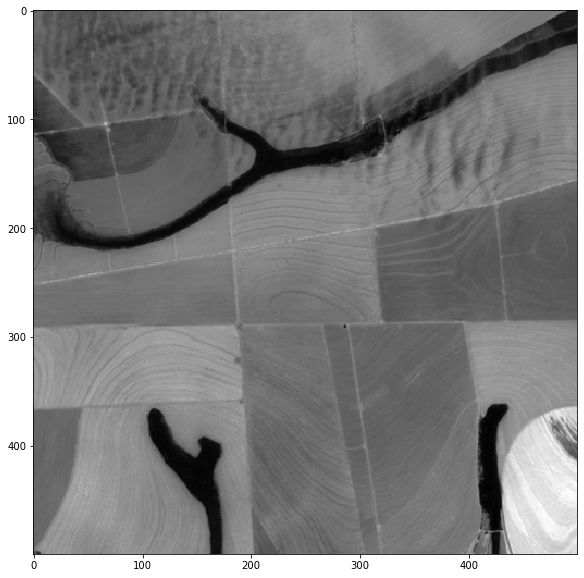

In [2]:
# raw image
img = cv2.imread("./data/talhao_101035/interest_b0420201015.tif", -1)
#img = cv2.imread("./data/talhao_103330/interest_b0420201217.tif", -1)
#img = cv2.imread("./data/talhao_100767/interest_b0420201015.tif", -1)
#img = cv2.imread("./data/talhao_102996/interest_b0420201013.tif", -1)
#img = cv2.imread("./data/talhao_102939/interest_b0420201105.tif", -1)
# image converted to 8bits
img_8bits = cv2.convertScaleAbs(img, alpha=0.03)


img_equalized = cv2.equalizeHist(img_8bits)
img_blur = cv2.GaussianBlur(img_8bits, (5,5), 0 )
img_lap = cv2.Laplacian(img_8bits, cv2.CV_64F)
img_lap = np.uint8(np.absolute(img_lap))

plt.imshow(img_8bits,cmap = 'gray')
plt.show()

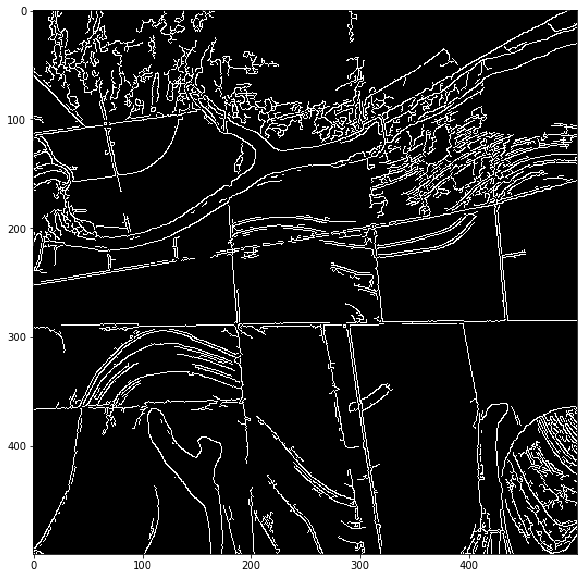

In [3]:
def get_8bits(img_source, show=False):    
    img_8bits = cv2.convertScaleAbs(img_source, alpha=0.03)
    if show:
        plt.imshow(img_8bits,cmap = 'gray')
        plt.show()
    return img_8bits

def get_edges(img_source, show=False):
    img_edges = cv2.Canny(img_source,10,50, None)
    if show:
        plt.imshow(img_edges,cmap = 'gray')
        plt.show()        
    return img_edges


def get_binary(img_source, show=False):
    img_blank = np.copy(img_source) * 0
    # make the image array a binary (0 background, 1 border)
    result = ""
    lines = len(img_blank)
    columns = len(img_blank[0])
    for line in range(lines):
        for column in range(columns):
            if img_source[line, column] > 0:
                img_blank[line, column] = 1
            else:
                img_blank[line, column] = 0
                
    if show:
        plt.imshow(img_blank,cmap = 'gray')
        plt.show() 
    return img_blank


img_8bits_test = get_8bits(img, show=False)
img_edges = get_edges(img_8bits_test, show=True)
img_edges_binary = get_binary(img_edges, show=False) 

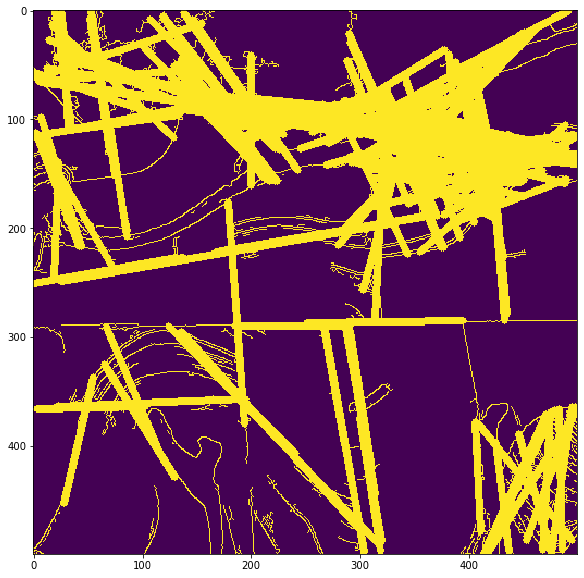

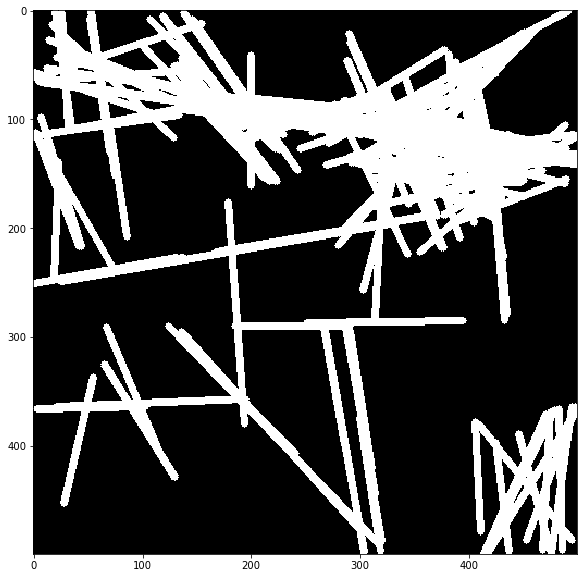

In [4]:
def get_hough_lines_p(img_source, 
                      rho,
                      theta,
                      threshold,
                      min_line_length,
                      max_line_gap,
                      stroke_size=5,
                      show=False):   
#     rho = 1  # distance resolution in pixels of the Hough grid
#     theta = np.pi / 180  # angular resolution in radians of the Hough grid
#     threshold = 15  # minimum number of votes (intersections in Hough grid cell)
#     min_line_length = 100  # minimum number of pixels making up a line
#     max_line_gap = 20

    img_copy = np.copy(img_source)
    img_blank = np.copy(img_source) * 0

    # maximum gap in pixels between connectable line segments
    lines_houghlinesp = cv2.HoughLinesP(img_copy, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    for line in lines_houghlinesp:
        for x1,y1,x2,y2 in line:
            cv2.line(img_copy,(x1,y1),(x2,y2),(255,0,0),stroke_size)
            cv2.line(img_blank,(x1,y1),(x2,y2),(255,0,0),stroke_size)

    if show:
        # show image merged
        plt.imshow(img_copy)
        plt.show()

        # show only lines
        plt.imshow(img_blank,cmap = 'gray')
        plt.show()
    
    return img_blank


hough_lines_p = get_hough_lines_p(img_edges, 
                                  rho=1, theta=np.pi / 180, 
                                  threshold=15,
                                  min_line_length=100,
                                  max_line_gap=20,
                                  stroke_size=5,
                                  show=True)

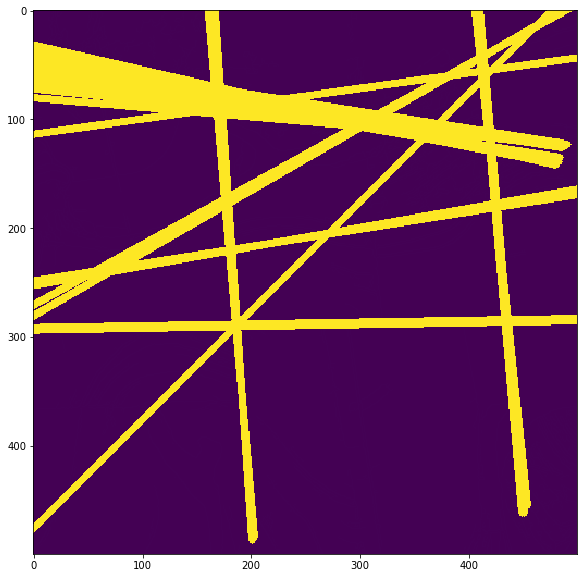

In [5]:
def get_hough_lines(img_source, 
                    rho, 
                    theta, 
                    threshold, 
                    line_length,
                    stroke_size=5,
                    show=False):    
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 132  # minimum number of votes (intersections in Hough grid cell)

    img_copy = np.copy(img_source)
    img_blank = np.copy(img_source) * 0

    lines_houghlines = cv2.HoughLines(img_copy, rho, theta, threshold)


    for line in lines_houghlines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + line_length*(-b))
        y1 = int(y0 + line_length*(a))
        x2 = int(x0 - line_length*(-b))
        y2 = int(y0 - line_length*(a))
        cv2.line(img_copy, (x1, y1), (x2, y2), (255, 0, 0), stroke_size)

    if show:
        # Draw the lines on the  image
        plt.imshow(img_copy)
        plt.show()
    return img_blank

hough_lines = get_hough_lines(img_edges_binary, 
                              rho=1, 
                              theta=np.pi / 180, 
                              threshold=132, 
                              line_length=500,
                              show=True) 


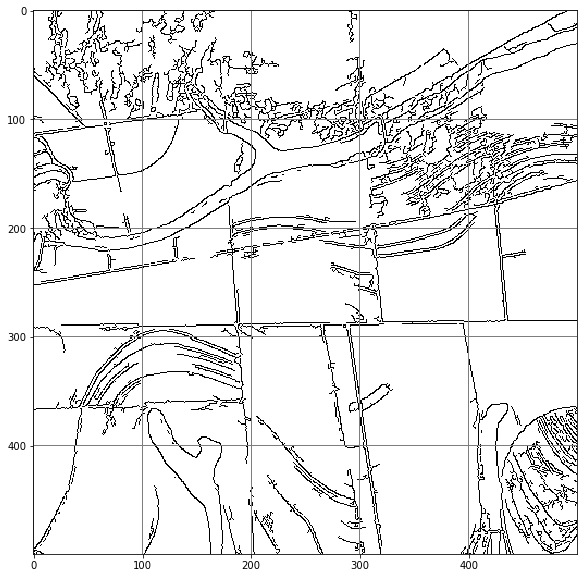

In [6]:
def print_grid(img_source, grid_size=100, show=False):
    img_grid = np.copy(img_source)
    img_grid = np.bitwise_not(img_grid) 
    height, width = img_grid.shape
    for x in range(0, width -1, grid_size):    
        cv2.line(img_grid, (x, 0), (x, height), (125,0,0), 1)

    for y in range(0, width -1, grid_size):
        cv2.line(img_grid, (0, y), (width, y), (125,0,0), 1)

    if show:
        plt.imshow(img_grid, cmap="gray")
        plt.show()
    return img_grid

img_grid = print_grid(img_edges, grid_size=100, show=True)


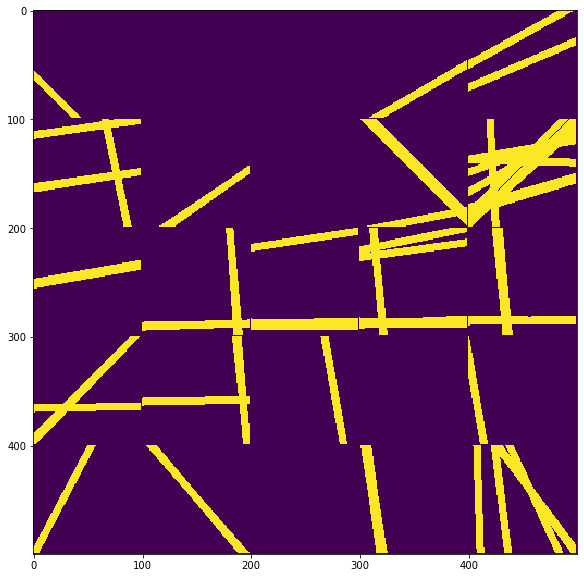

In [7]:
def get_hough_lines_grid(img_source, 
                         rho,
                         theta,
                         threshold,
                         line_length,
                         grid_size=100,
                         stroke_size=5,
                         show=False):
    
    max_rho =  math.sqrt(2 * grid_size **2)
    img_grid = np.copy(img_source)

    height, width = img_grid.shape
    new_image2 = np.copy(img_grid)
    for line in range(0, height-1, grid_size):    
        for column in range(0, width -1, grid_size):
            cell = img_grid[line:line+grid_size-1, column:column+grid_size-1]    
            cell_copy = np.copy(cell)       
            clean_cell = np.zeros((grid_size-1,grid_size-1))
            lines = cv2.HoughLines(cell, rho, theta, threshold)
            if not lines is None:
                for y in lines:
                    _rho,_theta = y[0]
                    a = np.cos(_theta)
                    b = np.sin(_theta)
                    x0 = a*_rho
                    y0 = b*_rho
                    x1 = int(x0 + max_rho*(-b))
                    y1 = int(y0 + max_rho*(a))
                    x2 = int(x0 - max_rho*(-b))
                    y2 = int(y0 - max_rho*(a))
                    cv2.line(clean_cell, (x1, y1), (x2, y2), (255,0,0), stroke_size)


            # Draw the lines on the  image
            img_cp = cv2.addWeighted(cell_copy, 0.8, cell, 1, 0)
            new_image2[line:line+grid_size-1, column:column+grid_size-1] = clean_cell


    if show:
        plt.imshow(new_image2)
        plt.show() 
    return new_image2

hough_lines_grid = get_hough_lines_grid(img_edges_binary, 
                              rho=1,
                              theta=np.pi / 180,
                              threshold=50,
                              line_length=1,
                              grid_size=100,
                              show=True) 


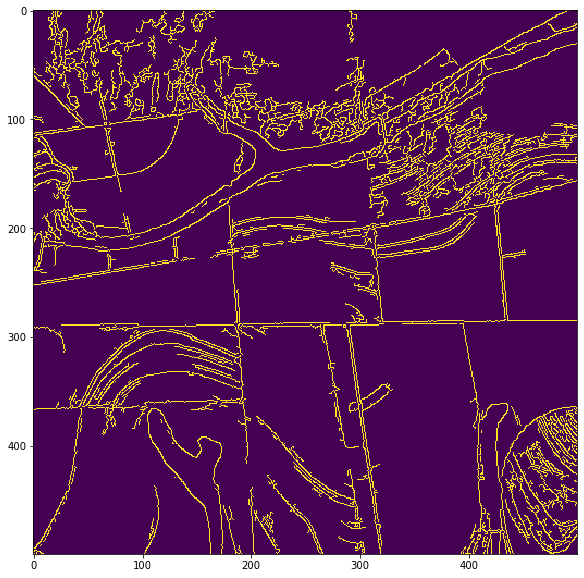

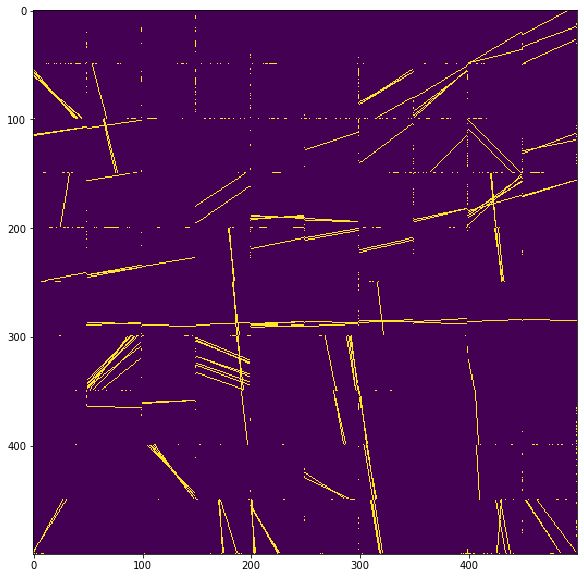

In [8]:
grid_size = 50

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 30  # minimum number of votes (intersections in Hough grid cell)

max_rho =  math.sqrt(2 * grid_size **2)

img_grid = np.copy(img_edges)

height, width = img_grid.shape
new_image2 = np.copy(img_grid)
for line in range(0, height-1, grid_size):    
    for column in range(0, width -1, grid_size):
        cell = img_grid[line:line+grid_size-1, column:column+grid_size-1]    
        cell_copy = np.copy(cell)       
        clean_cell = np.zeros((grid_size-1,grid_size-1))
        lines = cv2.HoughLines(cell, rho, theta, threshold)
        if not lines is None:
            for y in lines:
                _rho,_theta = y[0]
                a = np.cos(_theta)
                b = np.sin(_theta)
                x0 = a*_rho
                y0 = b*_rho
                x1 = int(x0 + max_rho*(-b))
                y1 = int(y0 + max_rho*(a))
                x2 = int(x0 - max_rho*(-b))
                y2 = int(y0 - max_rho*(a))
                cv2.line(clean_cell, (x1, y1), (x2, y2), (255,0,0), 1)
                
                
        # Draw the lines on the  image
        img_cp = cv2.addWeighted(cell_copy, 0.8, cell, 1, 0)
        new_image2[line:line+grid_size-1, column:column+grid_size-1] = clean_cell
                                       

plt.imshow(img_edges)
plt.show()
        
        
plt.imshow(new_image2)
plt.show()    

In [9]:
edges2 = cv2.Canny(new_image,10,50, None)
plt.imshow(edges2,cmap = 'gray')
plt.show()


edges3 = cv2.Canny(new_image2,10,50, None)
plt.imshow(edges3,cmap = 'gray')
plt.show()

NameError: name 'new_image' is not defined

In [ ]:

_rho = 10  # distance resolution in pixels of the Hough grid
_theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 20  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 25
grid_size = 100
max_rho =  math.sqrt(2 * grid_size **2)
img_grid = np.copy(img_edges)

height, width = img_grid.shape
new_image3 = np.copy(img_edges)

for line in range(0, height-1, grid_size):       
    for column in range(0, width -1, grid_size):
        cell = img_grid[line:line+grid_size-1, column:column+grid_size-1]    
        cell_copy = np.copy(cell)       
        clean_cell = np.zeros((grid_size-1,grid_size-1))
        lines = cv2.HoughLinesP(cell, _rho, _theta, threshold, np.array([]), min_line_length, max_line_gap)
        if not lines is None:
            for _line in lines:
                for x1,y1,x2,y2 in _line:
                    cv2.line(clean_cell,(x1,y1),(x2,y2),(255,0,0),1)


        # Draw the lines on the  image
        new_image3[line:line+grid_size-1, column:column+grid_size-1] = clean_cell

     
plt.imshow(new_image3)
plt.show()  


In [ ]:

_rho = 30  # distance resolution in pixels of the Hough grid
_theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 150  # minimum number of votes (intersections in Hough grid cell)
grid_size = 50
max_rho =  math.sqrt(2 * grid_size **2)
img_grid = np.copy(img_edges)

height, width = img_grid.shape
new_image3 = np.copy(img_edges)

for line in range(0, height-1, grid_size):       
    for column in range(0, width -1, grid_size):
        cell = img_grid[line:line+grid_size-1, column:column+grid_size-1]    
        cell_copy = np.copy(cell)       
        clean_cell = np.zeros((grid_size-1,grid_size-1))
        
        lines = cv2.HoughLines(cell, _rho, _theta, threshold)
        if not lines is None:
            for y in lines:
                rho,theta = y[0]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + max_rho*(-b))
                y1 = int(y0 + max_rho*(a))
                x2 = int(x0 - max_rho*(-b))
                y2 = int(y0 - max_rho*(a))
                cv2.line(clean_cell, (x1, y1), (x2, y2), (255,0,0), 1)

        
        
#         lines = cv2.HoughLinesP(cell, _rho, _theta, threshold, np.array([]), min_line_length, max_line_gap)
#         if not lines is None:
#             for _line in lines:
#                 for x1,y1,x2,y2 in _line:
#                     cv2.line(clean_cell,(x1,y1),(x2,y2),(255,0,0),1)


        # Draw the lines on the  image
        new_image3[line:line+grid_size-1, column:column+grid_size-1] = clean_cell

     
plt.imshow(new_image3)
plt.show()  
